Importing necessary packages

In [14]:
import numpy as np
import pandas as pd
import re
import time
import random
import binascii
import json
from pandas.io.json import json_normalize
from sklearn.model_selection import train_test_split
from random import seed
from random import randint
import itertools
from sklearn.utils import resample
import matplotlib.pyplot as plt

In [15]:
f = open('TVs-all-merged.json',)
data = json.load(f)

In [16]:
info = []

for i in range(len(list(data.values()))):
    if len(list(data.values())[i]) ==1:
        info.append(list(data.values())[i][0])
    else:
        for j in range(len(list(data.values())[i])):
            info.append(list(data.values())[i][1:][0])


In [17]:
columns = list(data.values())[0][0].keys()
df = pd.DataFrame(info,columns=columns)
df.columns

Index(['shop', 'url', 'modelID', 'featuresMap', 'title'], dtype='object')

In [19]:
##extract all double modelID's from datafile
dupID = df.pivot_table(columns=['modelID'], aggfunc='size')
dupID = dupID[dupID > 1]

# print(dupID)

##Enter a productID to check whether and how many times it is in the dataset 
#returns True when product is duplicate
#returns False when product is unique
def duplicateControl(productNumber):
    if df['title'][productNumber] in dupID:
        #print(y_data.iloc[productNumber], 'is contained in dupID')
        return True
    else:
        #print(y_data.iloc[productNumber], 'is not more than once in the dataset')
        return False    

duplicateControl(0)
dupID2 = pd.DataFrame(dupID)
for i in range(len(dupID2)):
    if dupID2[0][i] == 3:
        dupID2[0][i] = 3 
    if dupID2[0][i] == 4:# for duplicate sets of 4 there can be 6 pairs
        dupID2[0][i] = 6
        
print("Total amount of double products:", sum(dupID2[0]))
print("Total ammount of duplicate products:", len(dupID))

Total amount of double products: 699
Total ammount of duplicate products: 329


## Data Preprocessing ##

In [20]:
modelID_list = df['modelID'].tolist()

In [21]:
def preprocess(text):
    text = re.sub(r'[^\w\s]','',text)
    tokens = text.lower()
    tokens = tokens.split()
    return tokens

In [22]:
duplicate_IDs=[]
for i in range(len(df['title'])):
    if modelID_list.count(df['modelID'][i]) >= 2:

        duplicate_IDs.append(preprocess(df['modelID'][i]))

from itertools import chain
duplicate_IDs_list = list(chain.from_iterable(duplicate_IDs))
duplicate_IDs_list = list(set(duplicate_IDs_list))

In [23]:
df['title'].iloc[0]

'Philips 4000 Series 29" Class 2812" Diag. LED 720p 60Hz HDTV 29PFL4508F7 - Best Buy'

In [24]:
words=[]
for i in range(len(df['title'])):
    words.append(preprocess(df['title'].iloc[i]))
    
print(words[0])

['philips', '4000', 'series', '29', 'class', '2812', 'diag', 'led', '720p', '60hz', 'hdtv', '29pfl4508f7', 'best', 'buy']


In [25]:
def textfunc(A, index_sample):
    words = A.iloc[index_sample]
#     words = re.sub(r'[^\w\s]','', words)
    
    units = words.split()
    units = words.lower() #needed for modelID to be filtered
    return str(units)

print(textfunc(df['title'], 0)) #gives the title of the first product in x-trainset as strings


philips 4000 series 29" class 2812" diag. led 720p 60hz hdtv 29pfl4508f7 - best buy


In [26]:
listIDs = []
for i in range(len(df)):
    listIDs.append(textfunc(df['modelID'], i))  
    listIDs[i] = listIDs[i].replace('/', '')
    listIDs[i] = listIDs[i].replace('-', '')

In [27]:
totalWords = []
for i in range(len(df['title'])):
    totalWords.append(preprocess(df['title'].iloc[i]))

In [28]:
#Remove all double keywords
keyWords = []
for i in range(len(df)):
    for j in range(len(totalWords[i])):
        if totalWords[i][j] not in keyWords:
            keyWords.append(totalWords[i][j])
    #if listIDs[i] in keyWords: ##remove modelID's that are in titles
     #   keyWords.remove(listIDs[i])        

print(len(keyWords))

1534


## Input Matrix ##

In [29]:
#The input matrix has rows equal to number of keywords and columns equal to number of documents
input_matrix = np.zeros((len(keyWords), len(df['title'])))

#Loop first over the every shingle and check if this shingle is in each document. 
#That is, for the first shingle check if this word is in the first document, the first row and first column cell
#gets a 1. This is done for every document, ie every column and then for every shingle
for i in range(len(keyWords)):
    for j in range(len(df['title'])):
        if keyWords[i] in preprocess(df['title'][j]):
            input_matrix[i][j] = 1

## MinHashing ##

Find Random Numbers for MinHash 

In [30]:
#Create hashfunction  h(x) = (a +b*x) % p
def findRandom(k):
    randomList = []
    randomIndex = random.randint(0, len(keyWords) -1) 
    randomList.append(randomIndex)
    while k>0:
        while randomIndex in randomList:
            randomIndex = random.randint(0, len(keyWords)-1) 
      
        randomList.append(randomIndex)
        k = k-1
    
    return randomList

In [31]:
numHashes=500
A = findRandom(numHashes)
B = findRandom(numHashes)
p=1543 # next prime number after 1534
len(A)

501

## Perform MinHashing ##

In [158]:
#for each column, iterate over the rows and where there is a 1 calculate the hash function
#This hash function is updated over the rows where there is a 1 when the hash function is smaller
#than the previous value.
all_signatures=[]
for j in range(len(input_matrix[2])):
    signature=[]
    for k in range(0,numHashes):
        minHashCode = 2**32-1
        for i in range(len(input_matrix)):
            if input_matrix[i][j] == 1:
                hashCode = (A[k] + i*B[k]) % p
                if hashCode < minHashCode:
                    minHashCode = hashCode
        
        signature.append(minHashCode)
    all_signatures.append(signature)

In [33]:
signature_matrix = pd.DataFrame(all_signatures)
signature_matrix = pd.DataFrame.transpose(signature_matrix)

In [34]:
print(signature_matrix)

     0     1     2     3     4     5     6     7     8     9     ...  1614  \
0      66   119    23    23    23    23    23    23    23    23  ...   119   
1      33   510    18    18    33    18    33     3    33    33  ...   234   
2     110    94    46    30    14    62   110   110   110   126  ...    94   
3      29    85   141   141   141   141    34    34    34   141  ...    85   
4     102   102    17    17    55    17   216   263    93   102  ...   341   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
495    14   588    29    14    29    44   126   126   126   193  ...   141   
496    61   147    68    61    68    68    68    68    68    68  ...    52   
497    98   309    76   109    65   276    54    54    43   109  ...   245   
498   136   316   147   147     0   158   147    11    11    11  ...   316   
499    54   315    54     6   125    77    54    54    54    77  ...   315   

     1615  1616  1617  1618  1619  1620  1621  1622  1623  
0  

## LSH ##

In [298]:
#Adjust number of bands using second input. Different values of the band are
#tested and pair completeness, pair quality and f1* measure are compared
all_bands = np.vsplit(signature_matrix,50)
for x in range(len(all_bands)):
    all_bands[x].reset_index(inplace=True,drop=True)

In [299]:
#Loop through each column of each band and aggregate the hash values from each row
#If two columns have the same hash value they are put into the same bucket
buckets={}
b=len(all_bands)
for band in range(b):
    for col in range(len(signature_matrix.iloc[0])):
        s = [str(all_bands[band][col][i]) for i in range(len(all_bands[band][col]))]
        h = int("".join(s))
        
        if h in buckets.keys():
            buckets[h].append(col)
        else:
            buckets[h] = [col]
        

In [300]:
len(buckets)

58635

In [301]:
#If values of buckets greater than one then add the value to 
#candidate buckets dictionary, with hash function as the key.
#If not add to a dictionary where keys contain only 1 value
candidate_buckets = {}
non_duplicate_buckets={}
for key_b in buckets:
    if len(buckets[key_b]) > 1:
        candidate_buckets[key_b]=buckets[key_b]
    else:
        non_duplicate_buckets[key_b]=buckets[key_b]
        
print(len(candidate_buckets.values()))
print(len(non_duplicate_buckets.values()))


18402
40233


In [302]:
#As there are keys with the same values due to duplicates having the same hash function
#in each band we remove duplicate values from both candidate pairs and non duplicates
humid=list()
for key_n in non_duplicate_buckets:
    if non_duplicate_buckets[key_n] not in humid:
        humid.append(non_duplicate_buckets[key_n])
        

In [303]:
temp = list()
for key_d in candidate_buckets:
    if candidate_buckets[key_d] not in temp:
        temp.append(candidate_buckets[key_d])


In [304]:
print(len(temp),len(humid),len(temp)+len(humid))

1726 893 2619


In [305]:
#Look for candidates with more than 2 values and get every combination of those values 
#Example [1,2,3] = [1,2],[2,3][1,3]
#Remove the original values longer than 2 from the list and and add the list with all combinations
#Thus our final list - temp of duplicates contains only pairs.
more_than_2 =[]
for k in range(len(temp)):
    if len(temp[k]) > 2:
        more_than_2.append(temp[k])
        
print(len(more_than_2))

807


In [306]:
new_pairs=[]
for i in range(len(more_than_2)):
    res = [(a, b) for idx, a in enumerate(more_than_2[i]) for b in more_than_2[i][idx + 1:]]
    for a,b in res:
        if [b,a] not in new_pairs: #dont count [1,2] and [2,1] as different
            new_pairs.append([a,b])
            
print(len(new_pairs))

6116


In [307]:
for j in range(len(new_pairs)):
    if new_pairs[j] not in temp:
        temp.append(new_pairs[j])
        
print(len(temp))

4956


In [308]:
for l in range(len(more_than_2)):
    temp.remove(more_than_2[l])

In [309]:
print(len(temp))

4149


## Evaluation of LSH ##

In [310]:
true =0
false=0
for y in range(len(temp)):
    if df['modelID'][temp[y][0]] == df['modelID'][temp[y][1]]:
        true+=1
    
    if df['modelID'][temp[y][0]] != df['modelID'][temp[y][1]]:
        false+=1
        

In [311]:
pair_quality = true/len(temp)
pair_completeness = true/(sum(dupID2[0]))

f1_star = (pair_quality*pair_completeness)/(pair_quality+pair_completeness)

In [312]:
print(true,false,len(temp),f1_star,pair_completeness,pair_quality)

399 3750 4149 0.0823019801980198 0.5708154506437768 0.09616775126536514


In [242]:
thresholdPairs=[(1, 500), (2, 250), (5, 100), (10, 50), (20, 25),(25,20),(50,10)]
t=[]
for b,r in thresholdPairs:
    threshold=(1/b)**(1/r)
    t.append(threshold)
print(t)

[1.0, 0.9972312513520695, 0.9840344433634576, 0.954992586021436, 0.8870718549931568, 0.8513399225207846, 0.6762433378062414]


In [243]:
all_pair_quality=[0.9125799573560768,0.9172413793103448,0.9172413793103448,0.9151376146788991,0.822680412371134,0.6384,0.11083333333333334]
all_pair_completeness=[0.6123032904148784,0.5708154506437768,0.5708154506437768,0.5708154506437768,0.5708154506437768,0.5708154506437768,0.5708154506437768]
all_f1_star=[0.3664383561643835,0.3518518518518518,0.3518518518518518,0.3515418502202643,0.33699324324324326,0.30135951661631416,0.09281228192602932]







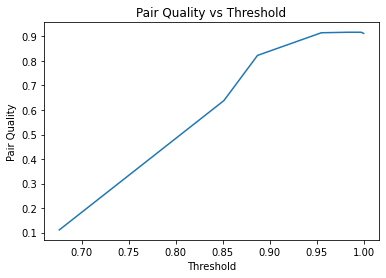

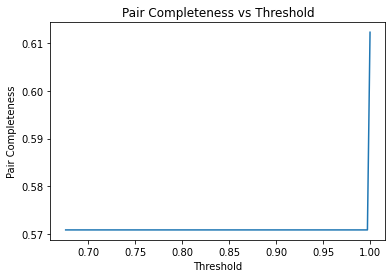

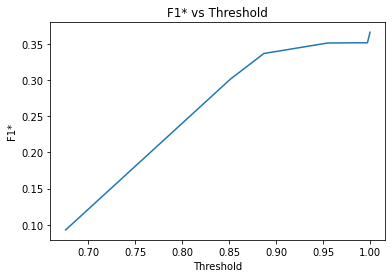

In [244]:
plt.plot(t, all_pair_quality)
plt.title('Pair Quality vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Pair Quality')
plt.show()

plt.plot(t, all_pair_completeness)
plt.title('Pair Completeness vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Pair Completeness')
plt.show()


plt.plot(t, all_f1_star)
plt.title('F1* vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1*')
plt.show()

## Jaccard Similarity and Signature Similarity ##

In [274]:
def jaccard_binary(x,y):
    """A function for finding the similarity between two binary vectors"""
    intersection = np.logical_and(x, y)
    union = np.logical_or(x, y)
    similarity = intersection.sum() / float(union.sum())
    return similarity

In [275]:
jaccard_similarity=[]
for t in range(len(temp)):
    jaccard_similarity.append(jaccard_binary(input_matrix[:,temp[t][0]],input_matrix[:,temp[t][1]]))

In [276]:
sigSimilarity = []
for i in range(len(temp)):
    num=0
    for j in range(len(signature_matrix[0])):
        if signature_matrix[temp[i][0]][j] == signature_matrix[temp[i][1]][j]:
            num+=1
    fraction=num/(len(signature_matrix[0]))
    sigSimilarity.append(fraction)


In [277]:
similarity_matrix = pd.DataFrame({'Jaccard Similarity':jaccard_similarity,'Sig Similarity':sigSimilarity})
predicted_duplicates =[0]*len(similarity_matrix)
#print(similarity_matrix)
for x in range(len(similarity_matrix)):
    if similarity_matrix.iloc[x][0] > 0.8 and similarity_matrix.iloc[x][1]>0.8:
        predicted_duplicates[x] = 1
        
#print(predicted_duplicates)
    

In [278]:
similarity_matrix['Pair'] =temp

In [279]:
similarity_matrix['Y'] = predicted_duplicates

In [280]:
sum(similarity_matrix['Y'])

518

## Classification ##

In [281]:
TP=0
FP=0
FN=0
for c in range(len(similarity_matrix)):
    if similarity_matrix['Y'][c] == 1:
    
        if df['modelID'][similarity_matrix['Pair'][c][0]] == df['modelID'][similarity_matrix['Pair'][c][1]]:
            TP+=1
        else:
            FP+=1
            
FN=total_number_of_duplicates-TP
print(TP,FP,FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = 2*precision*recall/(precision+recall)
print(precision,recall,f1)


399 119 300
0.7702702702702703 0.5708154506437768 0.6557107641741988


The threshold for r= 500 and b= 1 is: 1.0
The threshold for r= 250 and b= 2 is: 0.9972312513520695
The threshold for r= 100 and b= 5 is: 0.9840344433634576
The threshold for r= 50 and b= 10 is: 0.954992586021436
The threshold for r= 25 and b= 20 is: 0.8870718549931568
The threshold for r= 20 and b= 25 is: 0.8513399225207846


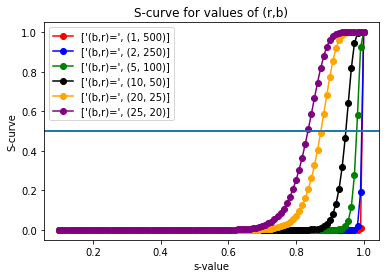

In [316]:
import matplotlib.pyplot as plt
thresholdPairs=[(1, 500), (2, 250), (5, 100), (10, 50), (20, 25),(25,20)]
c = np.linspace(0.1,1,100)
col = ["red", "blue", "green", "black", "orange", "purple",]
# lab = ["r=3, b=10", "r=6, b=20", "r=5, b=50"]
threshold = [0,0,0,0,0,0]

def function(A, col):
    plt.plot(c, 1 - (1-c**A[1])**A[0], color=col, marker='o', label=['(b,r)=',A])
    plt.ylabel("S-curve"); plt.xlabel("s-value")
    plt.axhline(0.5)
    plt.title("S-curve for values of (r,b)")
    
for i in range(len(thresholdPairs)):
    function(thresholdPairs[i], col[i])
    threshold[i] = (1/thresholdPairs[i][0])**(1/thresholdPairs[i][1]) #approximations
    print("The threshold for r=",  thresholdPairs[i][1], "and b=", thresholdPairs[i][0], "is:", threshold[i])
#     plt.axvline(threshold[i], color=col[i], linestyle="--")
    plt.legend() 